In [20]:
import numpy as np
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point
import random
from shapely import affinity
import matplotlib.pyplot as plt
%matplotlib notebook

In [21]:
class Room():        
    def __init__(self, shape):
        self.shape = shape
        self.polygon = Polygon(np.array(shape, dtype=np.float64))

In [22]:
class FurnitureItem(): 
    def __init__(self, unitcost, shape):
        self.shape = shape
        self.unit_cost = unitcost
        self.polygon = Polygon(np.array(shape, dtype=np.float64))
        self.total_cost = np.float64((np.float64(self.unit_cost) * self.polygon.area))

In [23]:
class Problem():
    def __init__(self, room, furniture):
        self.room = room
        self.furniture = furniture

In [24]:
problems = []
with open('problems.rfp') as f:
    for line in f:
        furnitureList = []
        problem = line.replace(" ","").split("#")

        room_shape = problem[0].split(":")[1]
        furniture = problem[1].split(";")

        room = Room([tuple(np.float64(i) for i in el.strip('()').split(',')) for el in room_shape.split('),(')])

        for furnitureItem in furniture:
            parse_furniture = furnitureItem.strip().split(":")
            unit_cost = parse_furniture[0]
            shape = [tuple(np.float64(i) for i in el.strip('()').split(',')) for el in parse_furniture[1].split('),(')]
            furnitureItem = FurnitureItem(unit_cost, shape)
            furnitureList.append(furnitureItem)
        problems.append(Problem(room,furnitureList))

In [25]:
def plot(poly):
    x,y = poly.exterior.xy
    plt.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.show()

In [26]:
len(problems[0].furniture)

94

In [191]:
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
    return points

In [255]:
solution = []
room_2 = problems[23].room.polygon
shapes = copy.copy(problems[23].furniture)
initial_area = room_2.area
while ((initial_area-room_2.area)/initial_area) < 0.3:
    for j in shapes:
        points = random_points_within(room_2,1)[0]
        polygon = affinity.translate(j.polygon, points.x, points.y)
        polygon = affinity.rotate(polygon, random.uniform(0,90),origin="centroid")
        if room_2.contains(polygon):
            room_2 = room_2.difference(polygon)
            x,y = polygon.exterior.xy
            solution.append(list(zip(*(x,y))))
            shapes.remove(j)
            print(len(shapes), (initial_area-room_2.area)/initial_area)
room_2.area

499 0.005106209150326798
498 0.00837418300653595
497 0.0116421568627451
496 0.014910130718954251
495 0.018178104575163404
494 0.021446078431372553
493 0.024714052287581705
492 0.027982026143790854
491 0.03125000000000001
490 0.03635620915032681
489 0.03962418300653595
488 0.042892156862745105
487 0.04616013071895426
486 0.04942810457516341
485 0.052696078431372556
484 0.060049019607843146
483 0.0633169934640523
482 0.06658496732026145
481 0.0698529411764706
480 0.0749591503267974
479 0.07822712418300655
478 0.0814950980392157
477 0.08476307189542485
476 0.08986928104575165
475 0.0931372549019608
474 0.09640522875816995
473 0.0996732026143791
472 0.10294117647058826
471 0.10804738562091505
470 0.11315359477124184
469 0.116421568627451
468 0.1215277777777778
467 0.12479575163398696
466 0.1280637254901961
465 0.13133169934640526
464 0.1345996732026144
463 0.13786764705882357
462 0.1411356209150327
461 0.14440359477124184
460 0.147671568627451
459 0.15093954248366015
458 0.1542075163398693

214.12499999999994

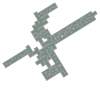

In [256]:
room_2

In [258]:
output = ""
for x in solution:
    output = output + str(x[:-1]).replace('[','').replace(']','') + "; "
print(output)

(5.29462198417942, -1.2206042311771599), (6.162550211406892, -0.32104845615163313), (5.262994436381364, 0.5468797710758402), (4.395066209153892, -0.35267600394968834); (16.914444028400588, 8.019967437418382), (17.216527755896553, 7.066686040567406), (18.169809152747526, 7.3687697680633715), (17.867725425251564, 8.322051164914344); (3.6964176115039074, -17.175604096119542), (4.535518027821581, -16.63162754208848), (3.9915414737905195, -15.792527125770807), (3.152441057472849, -16.33650367980187); (16.695722289133215, 5.976382967615237), (16.846390962517532, 6.964967284130832), (15.857806646001935, 7.115635957515149), (15.707137972617618, 6.127051640999554); (-0.4237152586788463, 2.6989713083735603), (-1.0460832021919593, 1.9162464889847417), (-0.2633583828031407, 1.2938785454716286), (0.3590095607099722, 2.076603364860447); (21.521539248172886, 11.805486215411882), (21.529096450190814, 10.805514771470776), (22.529067894131924, 10.813071973488714), (22.521510692113985, 11.813043417429817